# Importation des bibliothèques

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
import joblib

sns.set_theme()


#Chargement et préparation des données

In [16]:
df = pd.read_csv("/content/Land_mines.csv")  # adapte ce nom si besoin
X = df.drop("M", axis=1)
y = df["M"]

df.head()

,V,H,S,M
0,0.338157,0.000000,1,1
1,0.320241,0.181818,1,1
2,0.287009,0.272727,1,1
3,0.256284,0.454545,1,1
4,0.262840,0.545455,1,1


In [17]:
X = pd.get_dummies(X, columns=['S'], prefix='Soil').astype(float)
y = y.apply(lambda x: 0 if x == 1 else 1)

print(X)
print('\n')
print(y)

            V         H  Soil_1  Soil_2  Soil_3  Soil_4  Soil_5  Soil_6
0    0.338157  0.000000     1.0     0.0     0.0     0.0     0.0     0.0
1    0.320241  0.181818     1.0     0.0     0.0     0.0     0.0     0.0
2    0.287009  0.272727     1.0     0.0     0.0     0.0     0.0     0.0
3    0.256284  0.454545     1.0     0.0     0.0     0.0     0.0     0.0
4    0.262840  0.545455     1.0     0.0     0.0     0.0     0.0     0.0
..        ...       ...     ...     ...     ...     ...     ...     ...
333  0.323262  0.909091     0.0     0.0     1.0     0.0     0.0     0.0
334  0.444108  0.181818     0.0     0.0     0.0     0.0     0.0     1.0
335  0.353474  0.454545     0.0     0.0     0.0     0.0     0.0     1.0
336  0.362537  0.727273     0.0     0.0     0.0     0.0     0.0     1.0
337  0.314199  1.000000     0.0     0.0     0.0     0.0     0.0     1.0

[338 rows x 8 columns]


0      0
1      0
2      0
3      0
4      0
      ..
333    1
334    1
335    1
336    1
337    1
Name: M, Le

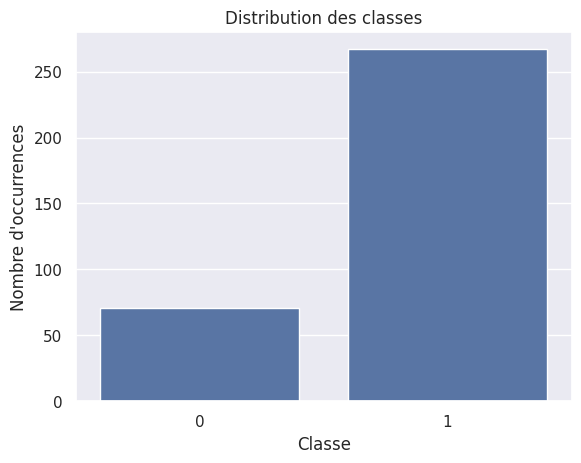

In [18]:
sns.countplot(x=y)
plt.title("Distribution des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurrences")
plt.show()


In [19]:
# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,stratify=y, test_size=0.2, random_state=42)


In [20]:
# Rééquilibrage des données (SMOTE)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

#Détection du meilleur modèle (Grid Search)

In [21]:
from sklearn.model_selection import GridSearchCV

# Tes modèles de base
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM (RBF)": SVC(probability=True),
    "MLP": MLPClassifier(max_iter=500)
}

# Grilles d'hyperparamètres à tester pour chaque modèle
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'solver': ['lbfgs'],
        'penalty': ['l2']
    },
    "Random Forest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
    },
    "KNN": {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    },
    "SVM (RBF)": {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    "MLP": {
        'hidden_layer_sizes': [(64,), (64, 32), (128, 64)],
        'activation': ['relu', 'tanh'],
        'learning_rate_init': [0.001, 0.01]
    }
}

best_estimators = {}
results = []

for name in models:
    print(f"Grid Search for {name}")
    grid_search = GridSearchCV(
        estimator=models[name],
        param_grid=param_grids[name],
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1,
        verbose=2
    )
    grid_search.fit(X_resampled, y_resampled)

    best_estimators[name] = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")
    print("*******************************************************")
    print(f"Best CV score (F1-weighted): {grid_search.best_score_:.4f}")

    # Evaluation sur le test set
    y_pred = grid_search.best_estimator_.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    results.append({
        "Model": name,
        "Test Accuracy": acc,
        "Test F1-score": f1,
        "Test Recall": recall
    })
df_results = pd.DataFrame(results).sort_values(by="Test F1-score", ascending=False).reset_index(drop=True)
print("*******************************************************")
print(df_results)


Grid Search for Logistic Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params for Logistic Regression: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
*******************************************************
Best CV score (F1-weighted): 0.9060
Grid Search for Random Forest
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
*******************************************************
Best CV score (F1-weighted): 0.9460
Grid Search for KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for KNN: {'n_neighbors': 3, 'weights': 'distance'}
*******************************************************
Best CV score (F1-weighted): 0.8815
Grid Search for SVM (RBF)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params for SVM (RBF): {'C': 10, 'gamma': 'scale'}
*******************************************************
Best CV score (F1-we

/tmp/ipython-input-22-678807618.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


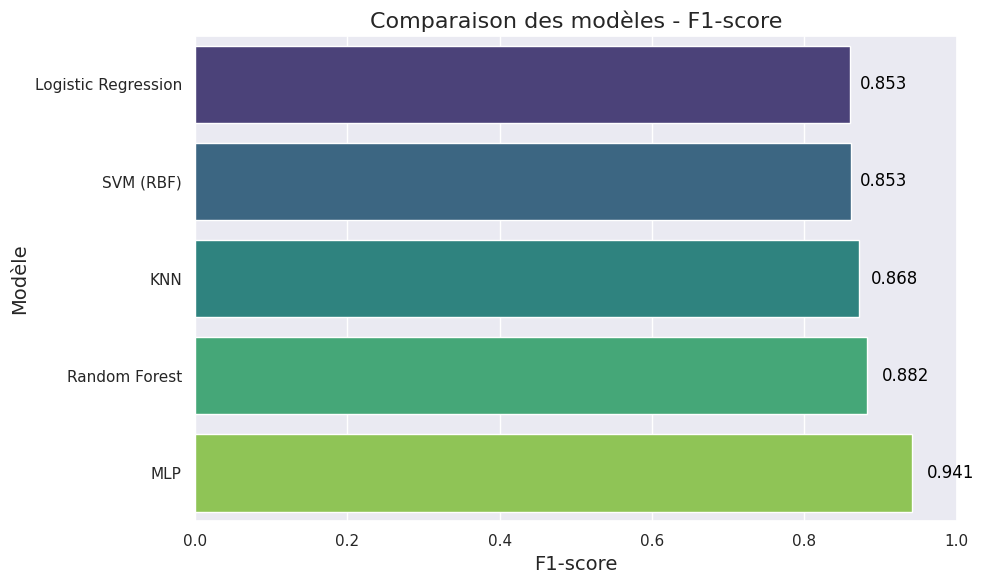

In [22]:
plt.figure(figsize=(10, 6))

# Trier les modèles par ordre décroissant de F1-score pour une meilleure lecture
df_results_sorted = df_results.sort_values(by="Test F1-score", ascending=True)

sns.barplot(
    x="Test F1-score",
    y="Model",
    data=df_results_sorted,
    palette="viridis"
)

plt.title("Comparaison des modèles - F1-score", fontsize=16)
plt.xlabel("F1-score", fontsize=14)
plt.ylabel("Modèle", fontsize=14)
plt.xlim(0, 1)  # les scores F1 sont toujours entre 0 et 1

# Afficher la valeur numérique de chaque barre à droite
for index, row in enumerate(df_results_sorted.itertuples()):
    plt.text(
        row._2 + 0.02,  # valeur F1 + un petit offset
        index,
        f"{row._2:.3f}",
        color='black',
        va="center"
    )

plt.tight_layout()
plt.show()


#Recherche des meilleurs paramètres pour le MLP

In [23]:
param_grid_mlp = {
    'hidden_layer_sizes': [(32,), (64,), (64, 32), (128, 64)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'solver': ['adam'],
    'max_iter': [500]
}

In [24]:
mlp = MLPClassifier(random_state=42)

grid_search_mlp = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring='f1',  # ou 'accuracy', ou 'roc_auc' selon ton objectif
    cv=5,          # cross-validation à 5 plis
    n_jobs=-1,
    verbose=2
)


In [25]:
grid_search_mlp.fit(X_resampled, y_resampled)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=MLPClassifier(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'hidden_layer_sizes': [(32,), (64,), (64, 32),
                                                (128, 64)],
                         'learning_rate_init': [0.001, 0.01], 'max_iter': [500],
                         'solver': ['adam']},
             scoring='f1', verbose=2)

In [26]:
grid_search_mlp.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (128, 64),
 'learning_rate_init': 0.001,
 'max_iter': 500,
 'solver': 'adam'}

In [28]:
print("Meilleurs hyperparamètres :", grid_search_mlp.best_params_)
print("Meilleur score F1 (cross-val) :", grid_search_mlp.best_score_)

# Évaluation sur le test set
from sklearn.metrics import classification_report

best_mlp = grid_search_mlp.best_estimator_
y_pred = best_mlp.predict(X_test)
print(classification_report(y_test, y_pred))


Meilleurs hyperparamètres : {'activation': 'relu', 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'adam'}
Meilleur score F1 (cross-val) : 0.9671215562511082
              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.96      0.94      0.95        54

    accuracy                           0.93        68
   macro avg       0.88      0.90      0.89        68
weighted avg       0.93      0.93      0.93        68



#Exportation du dataset

In [27]:
# save
joblib.dump(grid_search_mlp, "minetrack_magnetic_mlp.pkl")

['grid_search_mlp.pkl']